In [2]:
from fastai2.vision.all import * 

In [4]:
path = untar_data(URLs.PETS)

In [5]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [10]:
pets = DataBlock(blocks=(ImageBlock,CategoryBlock),get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'),
                 item_tfms=Resize(460), 
                 batch_tfms=aug_transforms(size=224,min_scale=0.75))
               

In [12]:
  dls = pets.dataloaders(path/"images")

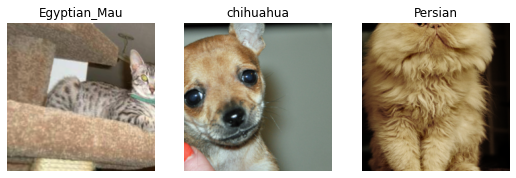

In [13]:
dls.show_batch(nrows=1,ncols=3)

In [14]:
learn = cnn_learner(dls,resnet34,metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.543865,0.351929,0.112314,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.503741,0.297463,0.090663,00:17
1,0.310285,0.230417,0.073748,00:16


In [16]:
#look at activations 
x,y = dls.one_batch()
y

TensorCategory([ 6, 20, 17,  0, 29,  3, 15,  7, 29, 24, 12, 16, 30,  4, 25, 34, 13,  3,
         5,  3, 17, 17, 26,  2,  1,  7, 19, 26, 21, 32,  7, 29,  5, 14, 13,  5,
        18, 16, 31, 14,  3, 32, 15, 26, 19, 16, 15, 13, 31, 19,  4, 19, 15, 18,
        29, 36,  6, 14, 11,  1, 22,  2,  7, 34], device='cuda:0')

In [41]:
#get preds
preds,_ = learn.get_preds(dl=[(x,y)])
preds[1]
print(preds[1].shape) #37 preds
preds[1].sum() #sum to 1 

torch.Size([37])


tensor(1.0000)

In [50]:
def softmax(x): 
    return torch.exp(x)/torch.exp(x).sum(dim=1,keepdim=True)
acts = torch.randn((3,2))
acts = softmax(acts)
acts

tensor([[0.1006, 0.8994],
        [0.6776, 0.3224],
        [0.0600, 0.9400]])

In [51]:
def log_likeli(inputs,targets): 
    inputs = inputs.sigmoid()
    return torch.where(targets==1,1-inputs,inputs).mean()
targ = torch.tensor([1,0,1])

In [52]:
idx = range(3)
idx

range(0, 3)

In [53]:
acts[idx,targ]

tensor([0.8994, 0.6776, 0.9400])

In [60]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 8),
 ('Egyptian_Mau', 'Bengal', 6),
 ('Ragdoll', 'Birman', 6),
 ('Ragdoll', 'Maine_Coon', 5)]

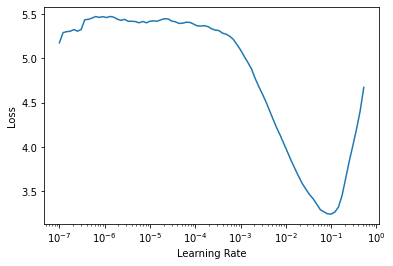

In [62]:
learn = cnn_learner(dls,resnet34,metrics=error_rate) 
lr_min, lr_steep = learn.lr_find()

In [64]:
learn = cnn_learner(dls,resnet34,metrics=error_rate)

In [65]:
learn.fine_tune(2,base_lr =3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.280865,0.352405,0.112991,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.551099,0.528440,0.144114,00:17
1,0.335746,0.260068,0.081867,00:17


In [66]:
learn = cnn_learner(dls,resnet34,metrics=error_rate)
learn.fit_one_cycle(3,3e-3)


epoch,train_loss,valid_loss,error_rate,time
0,1.140118,0.358555,0.098782,00:14
1,0.540779,0.278682,0.084574,00:13
2,0.316565,0.261844,0.077131,00:14


SuggestedLRs(lr_min=3.311311302240938e-05, lr_steep=9.12010818865383e-07)

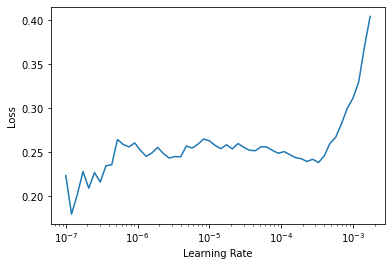

In [67]:
learn.unfreeze()
learn.lr_find()

fit_one_cycle is used for transfer learning when fine_tune is not used, it does allow more manual mods, fine_tune does : 
1) trains added layers for one epochs, with others frozen       
2) unfreeze all layers, trains them for # of epochs requested 

In [68]:
learn.fit_one_cycle(6,lr_max=5e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.259636,0.276930,0.086604,00:17
1,0.252533,0.269850,0.077131,00:17
2,0.206603,0.253138,0.078484,00:17
3,0.155274,0.242236,0.075778,00:17
4,0.124041,0.220900,0.067659,00:17
5,0.102783,0.218633,0.066982,00:17


In [69]:
learn = cnn_learner(dls,resnet34,metrics=error_rate)
learn.fit_one_cycle(3,3e-3)
learn.unfreeze()
learn.fit_one_cycle(12,lr_max=slice(1e-6,1e-4))


epoch,train_loss,valid_loss,error_rate,time
0,1.149260,0.428579,0.120433,00:14
1,0.535673,0.284045,0.085927,00:14
2,0.324423,0.250785,0.079838,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.256471,0.240286,0.077808,00:17
1,0.250458,0.239682,0.076455,00:17
2,0.233670,0.227020,0.074425,00:17
3,0.214571,0.227268,0.073072,00:17
4,0.183997,0.214839,0.065629,00:17
5,0.155247,0.212969,0.070365,00:17
6,0.140100,0.208967,0.069689,00:17
7,0.133471,0.213615,0.066982,00:17
8,0.139641,0.208448,0.064953,00:17
9,0.125654,0.208319,0.069689,00:17


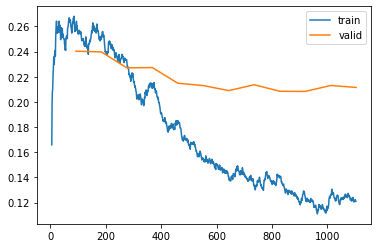

In [70]:
learn.recorder.plot_loss()